In [1]:
%load_ext cython
%matplotlib inline
import sys
sys.path.append('/home/bram/ANTS')
sys.path.append('/home/bram/ANTS/entropy')
for p in sys.path:
    print(p)


/usr/lib/python36.zip
/usr/lib/python3.6
/usr/lib/python3.6/lib-dynload
/home/bram/PythonEnvs/Ants/lib/python3.6/site-packages
/home/bram/PythonEnvs/Ants/lib/python3.6/site-packages/IPython/extensions
/home/bram/.ipython
/home/bram/ANTS
/home/bram/ANTS/entropy


In [4]:
%%cython -a
# distutils: language = c++

from libcpp.vector cimport vector
from cythonic.core.sim_controller cimport Sim
from cythonic.core.ant cimport ant_state
from cythonic.plugins.dummy_dicts import ant_dict, queen_dict, domain_dict, gauss_dict, sim_dict, deposit_dict
from cythonic.core.visualization import StigmergyPlot
import numpy as np
cimport numpy as cnp

from IPython.display import display, clear_output

sim_dict['n_agents'] = 100
gauss_dict['covariance'] = 5


cdef Sim simulator = Sim(queen_args = queen_dict, domain_args=domain_dict, **sim_dict)

simulator.set_depositing('constant', deposit_dict)
simulator.set_gaussian(**gauss_dict)
print(simulator.queen.count_active)
simulator.sim_step()
print(simulator.queen.count_active)
simulator.sim_step()
print(simulator.queen.count_active)
simulator.sim_step()
print(simulator.queen.count_active)
print(np.array(simulator.deploy_times))
print(simulator.t)


cdef cnp.ndarray[cnp.float_t, ndim=2] extractor(unsigned int * n, vector[ant_state]* state_list, unsigned int selector):
    """ put point x and y in numpy array [[x0,y0],[x1,y1],..,[xn,yn]]"""
    " if selector==0 -> extract ant position "
    " if selector==1 -> extract ant left antenna position "
    " if selector==2 -> extract ant right antenna position "
    
    cdef output = np.zeros([n[0],2],dtype = np.float_)
    cdef unsigned int i
    
    if selector == 0:
        for i in range(n[0]):
            output[i,0]= state_list[0][i].pos.x
            output[i,1] = state_list[0][i].pos.y
    elif selector== 1:
        for i in range(n[0]):
            output[i,0]= state_list[0][i].left.x
            output[i,1] = state_list[0][i].left.y
    elif selector==2:
        for i in range(n[0]):
            output[i,0]= state_list[0][i].right.x
            output[i,1] = state_list[0][i].right.y
    else:
        " not implemented, maybe throw an exception? "
        raise ValueError(f" selector == {selector} is not implemented ")
        
    return output
    
print(extractor(&simulator.queen.count_active, &simulator.queen.state_list, selector = 2))
# P = StigmergyPlot(simulator.domain.Map.dim.x, simulator.domain.Map.dim.y)
# P = Plotter(1e3,1e3)
import time


# for i in range(10):
#     simulator.sim_step()
#     P.draw_stigmergy(simulator.domain.Map.map)
    
#     display(P.fig)
#     time.sleep(.05)
#     clear_output(wait = True)

0
1
1
5
[ 0.          0.54923112  0.66918148  0.89154839  0.9271368   1.49438876
  1.68896528  1.69324992  1.79236857  2.06131106  2.29104631  2.51114048
  2.70848494  2.89767567  3.01653308  3.12150561  3.25888779  3.26824887
  3.2779341   3.38710371  3.40095119  3.53026221  3.76400208  3.88106474
  3.88254715  3.98739578  4.02159035  4.07807298  4.12190776  4.13550068
  4.1494807   4.16393075  4.49654337  4.56348174  4.59223836  4.61179459
  4.64426972  4.64681669  4.67829632  4.72844989  4.76485192  4.79794683
  5.0807936   5.19605242  5.28057294  5.28327757  5.28430915  5.37841131
  5.49142214  5.67608891  5.68079008  5.69521348  6.00323404  6.14576814
  6.20563084  6.38069234  6.5741399   6.70985814  6.80725519  6.99531135
  7.12464573  7.17906796  7.31603348  7.41807452  7.54756315  7.56721884
  7.62078469  7.7110172   7.88973885  7.94423758  7.95288104  8.08743123
  8.21992462  8.23491689  8.38210196  8.4914495   8.50626745  8.88076215
  8.96709873  9.47414409  9.54830826  9.573

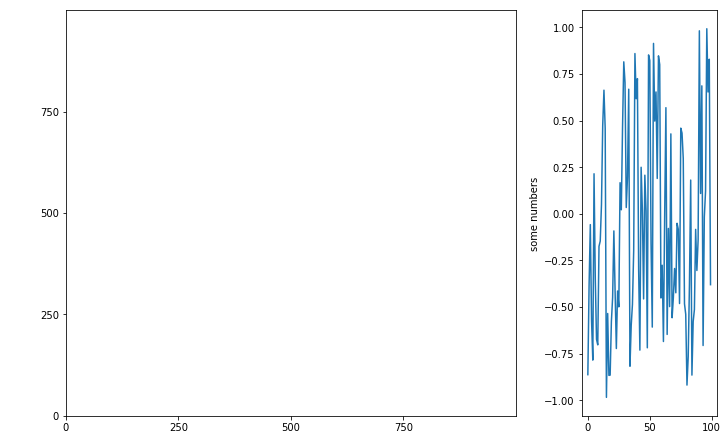

In [3]:
%%cython -a
# distutils: language = c++

from cythonic.plugins.dummy_dicts import ant_dict, queen_dict, domain_dict, gauss_dict, sim_dict, deposit_dict
from cythonic.core.sim_controller cimport Sim
from cythonic.core.visualization import StigmergyPlot

sim_dict['steps'] = 100

import time
from IPython.display import display, clear_output



cdef class live_sim(Sim):
    " parent class Sim does not have the __cinit__(self,....) constructor "
    cdef object chart # the graph object
    cdef unsigned int interval #how often to refresh the graph
    def __init__(self,queen_args, domain_args, sim_args):
        " initialize the parent class "
        super(live_sim,self).__init__(queen_args = queen_args,domain_args=domain_args, **sim_args)
        
        " setup the visualization part "
        self.chart = StigmergyPlot(x_lim = self.domain.size.x,y_lim = self.domain.size.y,
                                   colormap = 'blue', figsize = (10,6), shown = 'all')
        
        
        
    def setup_sim(self, str deposit_style, dict deposit_dict, dict gauss_dict, unsigned int display_interval):
        " prepare the simulation "
        self.set_depositing(deposit_style, deposit_dict )
        self.set_gaussian(**gauss_dict)
        self.interval = display_interval
        
    cpdef void run_sim(self):
        cdef unsigned int i
        for i in range(self.steps):
            self.sim_step()
            if i%self.interval == 0:
                self.chart.draw_stigmergy(simulator.domain.Map.map)
                display(self.chart.fig)
                clear_output(wait = True)
        
    
        
#     def setup_sim()
        
cdef live_sim simulator = live_sim(queen_args = queen_dict, domain_args=domain_dict, sim_args = sim_dict)

simulator.setup_sim('constant', deposit_dict, gauss_dict, display_interval = 1000,)
print(simulator.queen.count_active)
simulator.sim_step()
# simulator.run_sim()
clear_output(wait = True)

import numpy as np
import matplotlib.pyplot as plt
x = np.arange(0,sim_dict['steps'],1)
plt.plot(x,simulator.queen.state_list[0].noise_vec)
plt.ylabel('some numbers')
plt.show()
